In [1]:
# Imports
import pandas as pd
import numpy as np
import os

In [24]:
# Directory setup
BASE_DIR = ".."
COUNTRIES_DIR = os.path.join(BASE_DIR, 'data', 'countries')
OUTPUT_DIR = "../data/"

In [25]:
# Countries to process lsms data for
countries = ["eth"]

# Purchasing Power Parity
ppp = {"eth": 10.74}

# LSMS column names
survey_cols = ["household_id", "saq14", "hh_size", "total_cons_ann"]
geo_cols = ["household_id", "lat_mod", "lon_mod"]

In [26]:
def process_survey(country):
    consumption_file = country + "_consumption_lsms_raw.csv"
    geovariables_file = country + "_householdgeovariables_lsms_raw.csv"
    
    df_consumption = pd.read_csv(os.path.join(COUNTRIES_DIR, country, consumption_file))
    df_geovars = pd.read_csv(os.path.join(COUNTRIES_DIR, country, geovariables_file))
    
    df_consumption = df_consumption[survey_cols]
    # Calculate per capita daily household consumption: 
    df_consumption["cons_pc"] = df_consumption["total_cons_ann"] / df_consumption["hh_size"] / ppp[country] / 365 
    
    df_geovars = df_geovars[geo_cols]
    df_merged = pd.merge(df_consumption, df_geovars, on='household_id')
    df_merged["country"] = "ethiopia"
    
    # URBAN = 0, RURAL = 1
    df_merged["saq14"].replace(['URBAN', 'RURAL'], [0, 1], inplace=True)
    df_merged.rename(columns={'saq14': 'density', 'lat_mod': 'lat', 'lon_mod': 'lon', 'cons_pc': 'consumption'}, inplace=True)
    return df_merged[["country", "consumption", "density", "lat", "lon"]]

In [34]:
df_eth = process_survey(countries[0])

In [35]:
# Returns total number of NaN values
df_eth.isnull().sum().sum()

334

In [36]:
# Drops any rows with NaN values
df_eth = df_eth.dropna()

In [37]:
display(df_eth)

,country,consumption,density,lat,lon
0,ethiopia,7.114359,0,13.522697,39.440907
1,ethiopia,6.933497,1,9.602403,41.866592
2,ethiopia,7.354854,1,11.294477,36.448727
3,ethiopia,1.129382,1,9.503581,42.070496
4,ethiopia,1.924262,1,8.970294,36.525711
...,...,...,...,...,...
6675,ethiopia,4.283961,1,9.600062,41.245560
6676,ethiopia,2.158788,0,9.062462,38.757240
6677,ethiopia,1.986287,0,10.821666,40.187645
6678,ethiopia,2.943372,1,11.800598,37.128471


In [38]:
df_eth = df_eth.sort_values('consumption')
display(df_eth)

,country,consumption,density,lat,lon
5499,ethiopia,0.061442,1,14.029943,38.541546
6368,ethiopia,0.065432,1,14.029943,38.541546
539,ethiopia,0.112242,1,9.328209,42.142937
297,ethiopia,0.123466,1,7.879094,37.580292
2583,ethiopia,0.214926,1,6.375622,42.246292
...,...,...,...,...,...
3059,ethiopia,48.304890,0,8.968655,38.755150
4166,ethiopia,51.741537,0,8.978013,40.152702
1750,ethiopia,55.944543,0,13.490549,39.473690
1014,ethiopia,58.324226,0,8.987993,38.758446


       country  consumption  density        lat        lon
5499  ethiopia     0.061442        1  14.029943  38.541546
6368  ethiopia     0.065432        1  14.029943  38.541546
539   ethiopia     0.112242        1   9.328209  42.142937
297   ethiopia     0.123466        1   7.879094  37.580292
2583  ethiopia     0.214926        1   6.375622  42.246292
...        ...          ...      ...        ...        ...
3059  ethiopia    48.304890        0   8.968655  38.755150
4166  ethiopia    51.741537        0   8.978013  40.152702
1750  ethiopia    55.944543        0  13.490549  39.473690
1014  ethiopia    58.324226        0   8.987993  38.758446
5517  ethiopia    98.604962        0   9.346658  42.075893

[6513 rows x 5 columns]
Mean: 4.64419991542738
STD: 4.717155116197405
Distribution of consumption:


<AxesSubplot: ylabel='Frequency'>

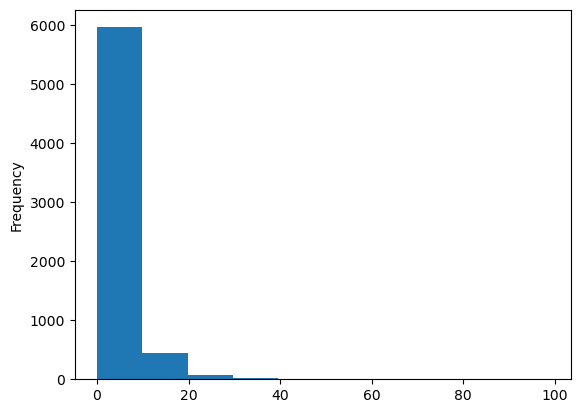

In [22]:
consumption = df_eth['consumption'].values.tolist()

print(df_eth)

print(f'Mean: {np.mean(consumption)}')
print(f'STD: {np.std(consumption)}')
print(f'Distribution of consumption:')
df_eth['consumption'].plot(kind='hist')

In [20]:
df_eth.to_csv(os.path.join(OUTPUT_DIR, 'lsms_clusters.csv'), index=False)